# IMDB Mean Encoding

### Introduction

In this lesson, we can practice using our cross validation library with the imdb dataset.  Let's again start by loading the data.

### Loading the Data

In [130]:
import pandas as pd

movies_df = pd.read_csv('./coerced_movies.csv', index_col = 0)

In [131]:
movies_df.shape

(799, 6)

In [132]:
# movies_df[:-1]

### Assigning and Coercing

Now, let's try mean encoding.

In [133]:
X = movies_df.drop('revenue', axis = 1)

In [134]:
y = movies_df['revenue']

### Feature Engineering 

In [135]:
from sklearn.model_selection import train_test_split

movies_train, movies_test = train_test_split(movies_df, test_size = .4, shuffle = False)
movies_validate, movies_test = train_test_split(movies_test, test_size = .5, shuffle = False)

In [136]:
movies_train[:3]

,genre,budget,runtime,year,month,revenue
235,Fantasy,97250400,116.0,2008,1,132900000
849,Crime,55000000,141.0,2008,1,113020255
1413,Drama,35000000,101.0,2008,1,32483410


In [137]:
genre_means = movies_train.groupby('genre').mean()['revenue']

In [138]:
genre_mean_dict = genre_means.to_dict()

In [139]:
genres_coerced = movies_train['genre'].map(genre_mean_dict)

In [140]:
movies_coerced = movies_train.assign(genre_means = genres_coerced)
movies_coerced = movies_coerced.drop('genre', axis = 1)

In [141]:
X_train = movies_coerced.drop('revenue', axis = 1)
y_train = movies_coerced['revenue']

In [142]:
from sklearn.ensemble import RandomForestRegressor
est = RandomForestRegressor(n_estimators = 100, max_depth = 30, max_features = 'log2', random_state = 1)
est.fit(X_train, y_train).score(X_train, y_train)

0.9292899404740033

We can see that this gives us an extremely high score on the training set.

However on the validation set, we do not perform as well.

In [143]:
genre_means_val = movies_validate['genre'].map(genre_mean_dict)

movies_val_coerced = movies_validate.assign(genre_means = genre_means_val)
X_validate = movies_val_coerced.drop(columns = ['genre', 'revenue'], axis = 1)
y_validate = movies_val_coerced['revenue']

In [144]:
est.score(X_validate, y_validate)

0.5007806403778132

This is a sign of overfitting to our training data.

### Regularization via Cross Validation

The overfitting can come in because we are using the knowledge about an observation's target an embedding it as a feature.

To avoid this, we can use cross validation to divide our data into K folds, and continually use the training folds to set on the mean on the one holdout fold.  Let's try it and see how we do.

In [145]:
from sklearn.model_selection import KFold

In [146]:
X_train = movies_train

In [147]:
train_new = X_train.copy()
col = 'genre'
target = 'revenue'
ts_folds = list(KFold(5).split(X_train))
tr_ind = ts_folds[0][0]
val_ind = ts_folds[0][1]


In [148]:
train_new = train_new.assign(genre_mean = train_new.revenue.mean())

In [149]:
X_tr, X_val = X_train.iloc[tr_ind], X_train.iloc[val_ind]
avg_mapper = X_tr.groupby(col).mean()[target].to_dict()
grouped_means = X_val[col].map(avg_mapper)
X_val = X_val.assign(genre_mean = grouped_means)
train_new.iloc[val_ind, :] = X_val

In [150]:
train_new.iloc[val_ind, :] = X_val

In [151]:
X_val.shape

(96, 7)

Now let's try this by looping through our folds.

In [152]:
train_new = X_train.copy()
col = 'genre'
target = 'revenue'
ts_folds = list(KFold(5, shuffle = True).split(X_train))

train_new = train_new.assign(genre_mean = train_new.revenue.mean())

for tr_ind, val_ind in ts_folds:
    X_tr, X_val = X_train.iloc[tr_ind], X_train.iloc[val_ind]
    avg_mapper = X_tr.groupby(col).mean()[target].to_dict()
    grouped_means = X_val[col].map(avg_mapper)
    X_val = X_val.assign(genre_mean = grouped_means)
    train_new.iloc[val_ind, :] = X_val

In [153]:
# train_new.genre_mean.value_counts()

In [154]:
target = 'revenue'
col = 'genre'
avg_cross_mapper = X_tr.groupby(col).mean()[target].to_dict()


Finally, we can see how we do.

> We remove the year column as we know that randomforests cannot extrapolate for trends outside of the dataset, and hear we are training on years through 2014, but ultimately want to predict for years in 2016.

In [155]:
X_train_new = train_new.drop(columns = ['genre', 'revenue', 'year'])
y_train_new = train_new['revenue']

In [156]:
val_genre_avg = movies_validate['genre'].map(avg_cross_mapper)
movies_validate = movies_validate.assign(genre_mean = val_genre_avg)

In [157]:
X_val_smoothed = movies_validate.drop(columns = ['genre', 'revenue', 'year'])
y_val_smoothed = movies_validate['revenue']

In [158]:
from sklearn.ensemble import RandomForestRegressor
est_2 = RandomForestRegressor(n_estimators = 100, max_depth = 30, max_features = 'log2')
est_2.fit(X_train_new, y_train_new).score(X_train_new, y_train_new)




0.9281783155388602

In [159]:
est_2.score(X_val_smoothed, y_val_smoothed)

0.4610091249061321

### Hyperparameter Search

In [160]:
scores = [RandomForestRegressor(n_estimators = 100, max_depth = depth, max_features = 'log2').fit(X_train_new, y_train_new).score(X_val_smoothed, y_val_smoothed) for depth in range(1, 40)]

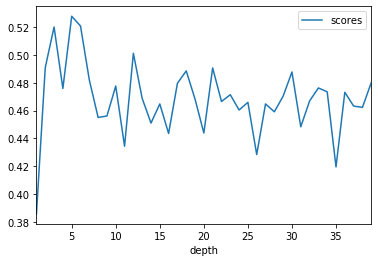

In [161]:
df_scores = pd.DataFrame({'depth': range(1, 40), 'scores':scores})
df_scores.plot(x = 'depth', y = 'scores')

In [162]:
df_scores[:20]

,depth,scores
0,1,0.385804
1,2,0.490902
2,3,0.519977
3,4,0.475859
4,5,0.527710
5,6,0.520696
6,7,0.481986
7,8,0.455049
8,9,0.456103
9,10,0.477605


In [163]:
[RandomForestRegressor(n_estimators = 100, max_depth = 5, max_features = max_feat).fit(X_train_new, y_train_new).score(X_val_smoothed, y_val_smoothed) for max_feat in ['log2', 'sqrt', .5, .4, .3, .2, .1, .08, .07, .05 ]]

[0.5216444800385278,
 0.4971036377936399,
 0.5098332712803673,
 0.4925697855485843,
 0.5055164362371386,
 0.5187672135132679,
 0.49144825039002776,
 0.4887176251055294,
 0.5008429828382588,
 0.49116246142090786]

In [164]:
X_train_new.shape, y_train.shape

((479, 4), (479,))

In [165]:
est = RandomForestRegressor(n_estimators = 100, max_depth = 5, max_features = 'log2')
est.fit(X_train_new, y_train_new).score(X_val_smoothed, y_val_smoothed)

0.47209857584817017

### Wrapping Up

Now that we have found our hyperparameters of `max_depth = 6` and `max_features = 'log2'`, we combine our entire training and validation sets to retrain.

In [166]:
movies_train[:3]

,genre,budget,runtime,year,month,revenue
235,Fantasy,97250400,116.0,2008,1,132900000
849,Crime,55000000,141.0,2008,1,113020255
1413,Drama,35000000,101.0,2008,1,32483410


In [167]:
movies_validate = movies_validate.drop('genre_mean', axis = 1)

In [168]:
movies_comb = pd.concat([movies_train, movies_validate], axis = 0)
movies_comb = movies_comb.reset_index().drop(columns = ['index', 'year'], axis = 1)

In [169]:
train_val_new = movies_comb.copy()
col = 'genre'
target = 'revenue'
ts_folds = list(KFold(5, shuffle = True).split(movies_comb))

train_val_new = train_val_new.assign(genre_mean = train_val_new.revenue.mean())

for tr_ind, val_ind in ts_folds:
    X_tr, X_val = movies_comb.iloc[tr_ind], movies_comb.iloc[val_ind]
    avg_mapper = X_tr.groupby(col).mean()[target].to_dict()
    grouped_means = X_val[col].map(avg_mapper)
    X_val = X_val.assign(genre_mean = grouped_means)
    train_val_new.iloc[val_ind, :] = X_val

In [170]:
X_train_val = train_val_new.drop(columns = ['genre', 'revenue'])
y_train_val = train_val_new['revenue']

In [171]:
# X_train_val

Then we need to calculate the average per genre to encode the test set.

In [172]:
target = 'revenue'
col = 'genre'
avg_cross_mapper = X_tr.groupby(col).mean()[target].to_dict()

val_genre_avg = movies_test['genre'].map(avg_cross_mapper)
movies_test = movies_test.assign(genre_mean = val_genre_avg)

In [173]:
X_test = movies_test.drop(columns = ['revenue', 'genre', 'year'])
y_test = movies_test['revenue']

Finally we train the randomforest.

In [180]:
final_est = RandomForestRegressor(n_estimators=200, max_features='log2', max_depth = 6)
final_est.fit(X_train_val, y_train_val)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=6,
                      max_features='log2', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=200,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [181]:
final_est.score(X_test, y_test)

0.47175098169631946

In [182]:
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.model_selection import TimeSeriesSplit

perm = PermutationImportance(est, random_state = 1).fit(X_train_new, y_train_new)
eli5.explain_weights_df(perm, feature_names = list(X_train_new.columns))

,feature,weight,std
0,budget,0.844310,0.068940
1,runtime,0.182496,0.027238
2,genre_mean,0.111146,0.016267
3,month,0.065861,0.020830


### Summary

[Mean Encoding](https://github.com/scikit-learn-contrib/category_encoders)

[Kaggle Mean Encoding](https://www.kaggle.com/vprokopev/mean-likelihood-encodings-a-comprehensive-study)